In [1]:
import io
import json
import requests
import time 

from dateutil.parser import parse
from collections import defaultdict
from datetime import datetime, timezone, timedelta

import matplotlib
import matplotlib.pyplot as plt

from google.cloud import storage

In [2]:
class API:
    url = f"https://api.luchtmeetnet.nl/open_api/measurements"

    def get(self, station=None, start=None, end=None, formula=None):
        request_url = self.url

        # blegh - query string params
        # TODO something with station
        qsp_to_add = ["station_number=NL10404"]

        if start and end:
            qsp_to_add.append(f"start={start}")
            qsp_to_add.append(f"end={end}")
        if formula:
            qsp_to_add.append(f"formula={formula}")

        if len(qsp_to_add) > 0:
            stuff = "&".join(qsp_to_add)
            request_url += f"?{stuff}"

        try:
            response = requests.get(request_url)
            response.raise_for_status()
        except requests.exceptions.RequestException as e:
            print('Something went wrong while getting data from api: ', e)
            return []

        response_json = response.json()

        if 'pagination' in response_json:
            current_page = response_json['pagination']['current_page']
            last_page = response_json['pagination']['last_page']
            if current_page != last_page:
                print("TODO - pagination needed")

        response_data = response_json['data']

        return response_data

class LuchtmeetnetData:

    metrics = dict()
    measurements = defaultdict(dict)
    api = API()

    def __init__(self, formulas):
        for formula in formulas:
            self.metrics[formula] = Metric(formula)

    def add(self, data):
        for item in data:
            formula = item['formula']
            value = item['value']
            timestamp = item['timestamp_measured']

            metric = self.metrics[formula]

            self.measurements[formula][timestamp] = Measurement(metric, value, timestamp)

    def get_timestamp(self, formula, timestamp):
        if timestamp in self.measurements[formula]:
            delta_measurement = self.measurements[formula][timestamp]
            return delta_measurement
        else:
            new_data = self.api.get(start=timestamp, end=timestamp)
            
            if len(new_data) > 0:
                self.add(new_data)
                return self.get_timestamp(formula, timestamp)
            return None
    
    def get_time_range(self, start, end, formula):
        measurements_range = []
        
        dt_start, dt_end = parse(start), parse(end)
        
        dt_timestamp = dt_start
        
        while dt_timestamp <= dt_end:
            timestamp = dt_timestamp.isoformat()
            
            if timestamp in self.measurements[formula]:
                measurements_range.append(self.measurements[formula][timestamp])
            else:
                new_data = self.api.get(start=dt_start.isoformat(), end=dt_end.isoformat())

                if len(new_data) > 0:
                    self.add(new_data)
                    # ugly, but I don't want to keep looping
                    if timestamp in self.measurements[formula]:
                        measurements_range.append(self.measurements[formula][timestamp])
                    else:
                        measurements_range.append(Measurement(formula, None, timestamp)) # makes plotting life easier, but will regret this - probably

            dt_timestamp = dt_timestamp + timedelta(hours=1)
        
        return measurements_range

    def get_current_report(self):
        the_report = defaultdict(dict)
        timestamp = datetime.now(timezone.utc).replace(minute=0, second=0, microsecond=0).isoformat()

        for metric in self.measurements:
            current_measurement = self.measurements[formula][timestamp]
            the_report[formula]["NOW"] = current_measurement.evaluate()

            for enum, time_delta in time_deltas:
                result_time = current_measurement.timestamp - time_delta
                delta_time_string = result_time.isoformat()

                delta_measurement = self.get_timestamp(formula, delta_time_string)
                the_report[formula][enum] = current_measurement.compare(delta_measurement)

        return the_report

class Metric:
    metric_types = dict()
    metric_types['NO2'] = {'ub_good': 30, 'ub_med': 80, 'ub_bad': 100}
    metric_types['NO'] = {'ub_good': 30, 'ub_med': 100}
    metric_types['O3'] = {'ub_good': 40, 'ub_med': 180}
    metric_types['PM10'] = {'ub_good': 30, 'ub_med': 70, 'ub_bad': 100}
    metric_types['PM25'] = {'ub_good': 20, 'ub_med': 50, 'ub_bad': 100}

    ub_bad = float('inf') # why not?

    def __repr__(self):
        return f"<Metric: {self.formula}>"

    def __init__(self, formula):
        self.formula = formula
        metric_info = self.metric_types[self.formula]
        if 'ub_good' in metric_info:
            self.ub_good = metric_info['ub_good']
        if 'ub_med' in metric_info:
            self.ub_med = metric_info['ub_med']
        if 'ub_bad' in metric_info:
            self.ub_bad = metric_info['ub_bad']

    def judgement(self, value):
        if value <= self.ub_good:
            return "GOOD"
        elif value <= self.ub_med:
            return "MEDIOCRE"
        elif value <= self.ub_bad:
            return "BAD"
        else:
            return f"PANIC - {value}"

class Measurement:

    def __repr__(self):
        return f"<Measurement: {self.metric.formula}, {self.value}, {self.timestamp}>"

    def __init__(self, metric, value, timestamp):
        self.metric = metric
        if value:
            self.value = float(value) # better safe than sorry
        else:
            self.value = None
        self.timestamp = parse(timestamp)

    def evaluate(self):
        judgement = self.metric.judgement(self.value)
        return judgement

    def compare(self, other_measurement):
        diff = self.value - other_measurement.value
        return diff


In [3]:
# CONFIG // bit of manual setup to get exactly what we want
# dt = datetime(2020, 11, 27, 4, 2, 0, tzinfo=timezone.utc)

formulas = ['PM10', 'PM25', 'NO2', 'NO', 'O3']

data = LuchtmeetnetData(formulas)

time_deltas = []
time_deltas.append(("ONE_DAY", timedelta(days=1))) # one day
time_deltas.append(("ONE_WEEK", timedelta(days=7))) # one day
time_deltas.append(("ONE_MONTH", timedelta(days=30))) # one day
time_deltas.append(("ONE_YEAR", timedelta(days=365))) # one day

labels = dict()
labels[1] = 'day before'
labels[7] = 'last week'
labels[30] = 'last month'
labels[365] = 'last year'

colors = dict()
colors[1] = 'blue'
colors[7] = 'green'
colors[30] = 'orange'
colors[365] = 'purple'



In [4]:
def main(timestamp):
    # ignore timestamp for demo, instead use 2020-11-27
    dt = datetime(2020, 11, 27, 4, 2, 0, tzinfo=timezone.utc)
    
    more_context = [(x, dt - timedelta(days=x)) for x in [1, 7, 30, 365]]
    events = [dt]

    client = storage.Client(project='casebuilder-pro-3000')
    bucket = client.bucket('casebuilder-pro-3000-plots')
    urls = []

    for metric in formulas:
        filename = f'{int(time.time())}-{metric}.png' # kan Leo/Jaap/Guido vast mooier
        blob = bucket.blob(filename) 

        fig = plt.figure()

        # all of this, just because I want yesterday to be red :(
        for event in events:
            # this setup doesn't belong here, but it works
            start_time = event.replace(hour=0, minute=0, second=0, microsecond=0).isoformat()
            end_time = event.replace(hour=23, minute=0, second=0, microsecond=0).isoformat()

            values = data.get_time_range(start_time, end_time, metric)
            values = sorted(values, key = lambda x: x.timestamp)

            xs = list(range(24))
            ys = [x.value for x in values]

            plt.plot(xs, ys, label=f"yesterday", color='r', marker='o')


        for offset, event in more_context:
            # this setup doesn't belong here, but it works - II
            start_time = event.replace(hour=0, minute=0, second=0, microsecond=0).isoformat()
            end_time = event.replace(hour=23, minute=0, second=0, microsecond=0).isoformat()

            values = data.get_time_range(start_time, end_time, metric)
            values = sorted(values, key = lambda x: x.timestamp)

            xs = list(range(24))
            ys = [x.value for x in values]

            plt.plot(xs, ys, label=f"{labels[offset]}", marker='o', color=f"{colors[offset]}")


        plt.title(f"{metric}")
        plt.xlabel('time (h)')
        plt.ylabel('µg/m3')
        plt.xlim(0, 23)
        plt.ylim(0, 100)
        plt.grid()
        plt.legend()

        # temporarily save image to buffer
        buf = io.BytesIO()
        fig.savefig(buf, format='png')
        # upload buffer contents to gcs
        blob.upload_from_string(
            buf.getvalue(),
            content_type='image/png')

        buf.close()

        # gcs url to uploaded matplotlib image
        url = blob.public_url
        urls.append(url)

    #     plt.show()
    

    return urls

['https://storage.googleapis.com/casebuilder-pro-3000-plots/1606639994-PM10.png',
 'https://storage.googleapis.com/casebuilder-pro-3000-plots/1606639995-PM25.png',
 'https://storage.googleapis.com/casebuilder-pro-3000-plots/1606639995-NO2.png',
 'https://storage.googleapis.com/casebuilder-pro-3000-plots/1606639995-NO.png',
 'https://storage.googleapis.com/casebuilder-pro-3000-plots/1606639996-O3.png']

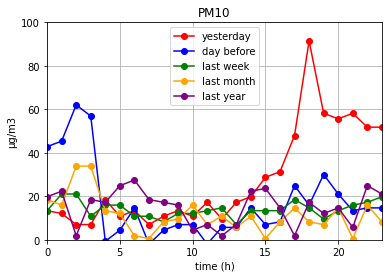

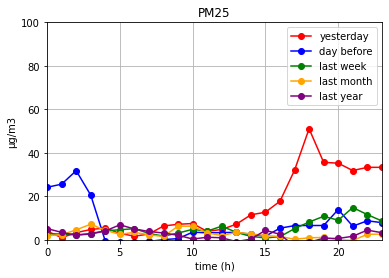

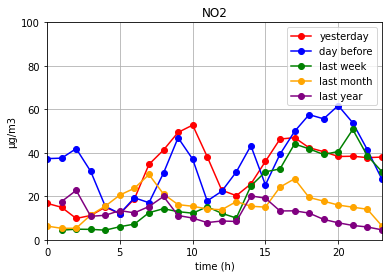

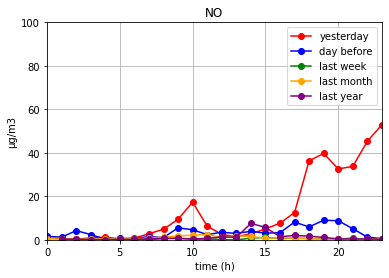

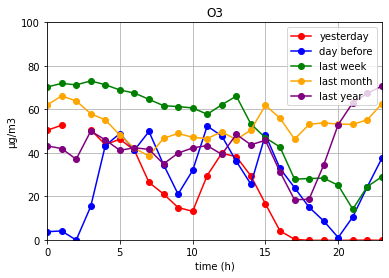

In [5]:
main('hi')